# Titanic Example

In [50]:
#Import libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.model_selection import GridSearchCV

## Loading Dataset

In [2]:
# Load the data
df = pd.read_csv('/kaggle/input/titanic/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()

# Display columns with missing values
print(missing_values[missing_values > 0])

Age         177
Cabin       687
Embarked      2
dtype: int64


## Cleaning and Preprocessing Data

In [5]:
# Drop the 'Cabin' column due to too many missing values
df = df.drop(columns=['Cabin'])

KeyError: "['Cabin'] not found in axis"

In [6]:
# Convert 'Sex' to numerical values (0 = male, 1 = female)
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

In [7]:
# Check the mode (most common value) of the 'Embarked' column
most_common_embarked = df['Embarked'].mode()[0]

# Fill missing values in 'Embarked' with the most common value using
df.loc[:, 'Embarked'] = df['Embarked'].fillna(most_common_embarked)

# Verify if all missing values in 'Embarked' are handled
print(df['Embarked'].isnull().sum())

0


In [8]:
# Fill missing Age values using the mean age of passengers with the same Sex, Pclass, SibSp, and Parch
df['Age'] = df.groupby(['Sex', 'Pclass', 'SibSp', 'Parch'])['Age'].transform(lambda x: x.fillna(x.mean()))

# For any remaining NaN values, fill using just Sex and Pclass
df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.mean()))

# Check if there are any missing Age values left
print(df['Age'].isnull().sum())

0


In [20]:
# Convert 'Embarked' to numerical values (S = 0, C = 1, Q = 2)
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

In [14]:
# Drop these columns since they don't give any information
df = df.drop(columns=['Name', 'Ticket', 'PassengerId'])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 55.8 KB


## EDA

In [22]:
# 1. Statistical Summary
print("Statistical Summary:\n", df.describe())

Statistical Summary:
          Survived      Pclass         Sex         Age       SibSp       Parch  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     0.383838    2.308642    0.352413   29.637059    0.523008    0.381594   
std      0.486592    0.836071    0.477990   13.437277    1.102743    0.806057   
min      0.000000    1.000000    0.000000    0.420000    0.000000    0.000000   
25%      0.000000    2.000000    0.000000   22.000000    0.000000    0.000000   
50%      0.000000    3.000000    0.000000   29.184492    0.000000    0.000000   
75%      1.000000    3.000000    1.000000   36.000000    1.000000    0.000000   
max      1.000000    3.000000    1.000000   80.000000    8.000000    6.000000   

             Fare    Embarked  
count  891.000000  891.000000  
mean    32.204208    0.361392  
std     49.693429    0.635673  
min      0.000000    0.000000  
25%      7.910400    0.000000  
50%     14.454200    0.000000  
75%     31.000000    1.0

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


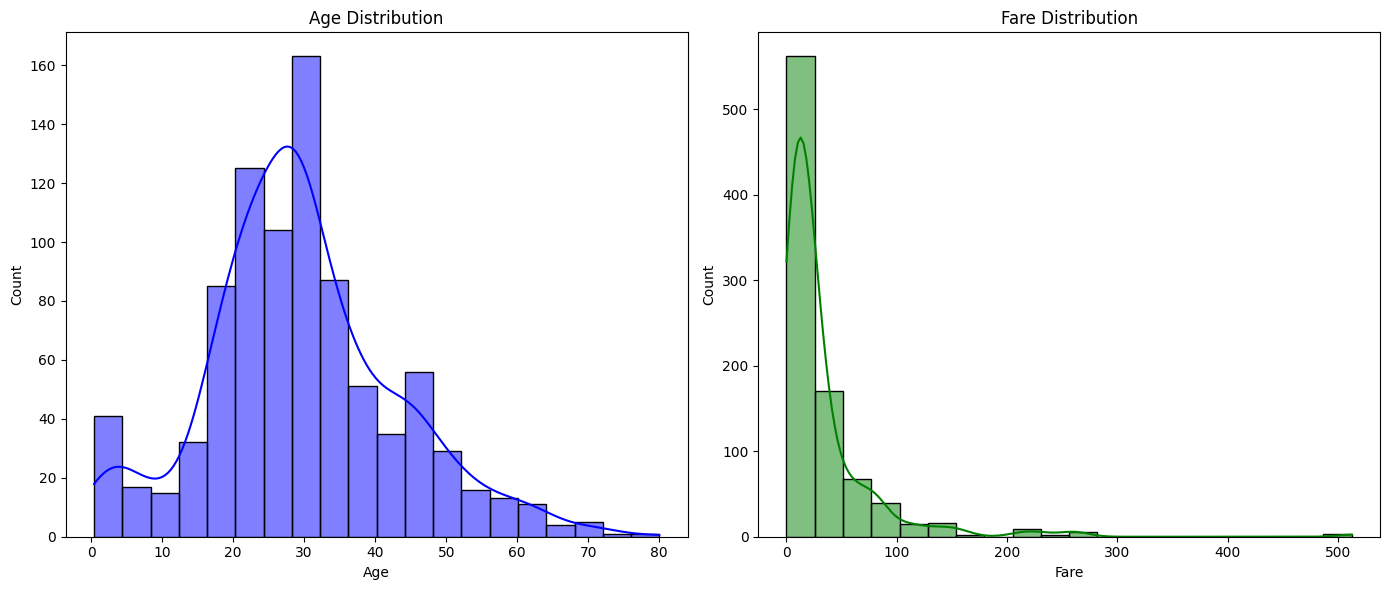

In [23]:
# 2. Distribution of Features
plt.figure(figsize=(14, 6))

# Distribution of Age
plt.subplot(1, 2, 1)
sns.histplot(df['Age'], bins=20, kde=True, color='blue')
plt.title('Age Distribution')

# Distribution of Fare
plt.subplot(1, 2, 2)
sns.histplot(df['Fare'], bins=20, kde=True, color='green')
plt.title('Fare Distribution')

plt.tight_layout()
plt.show()

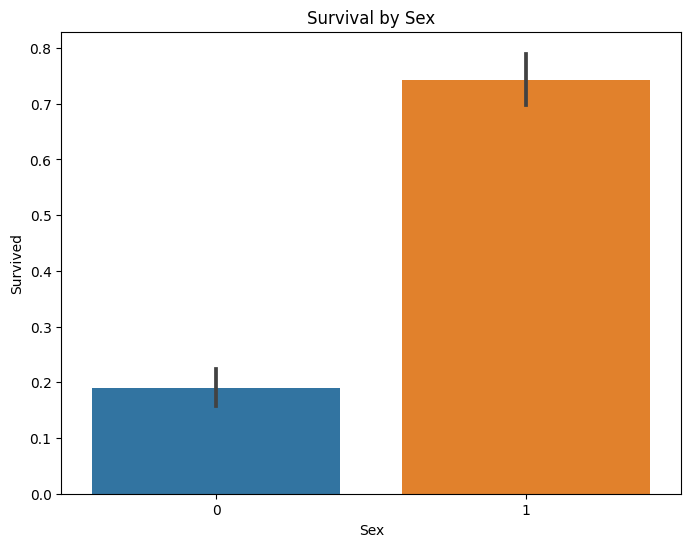

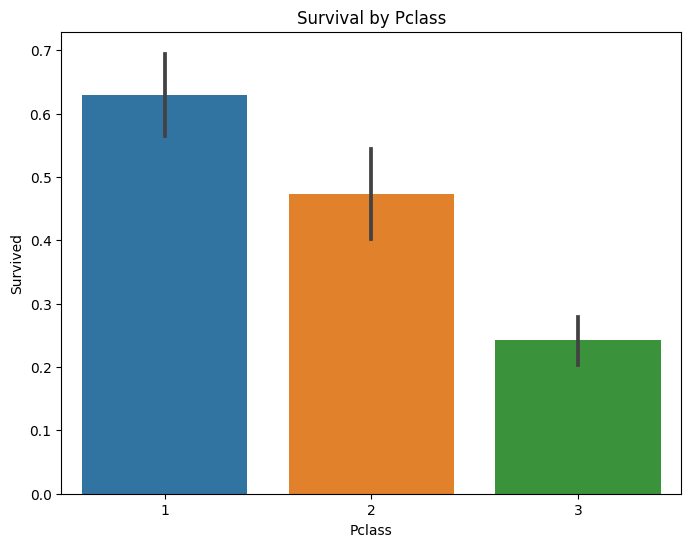

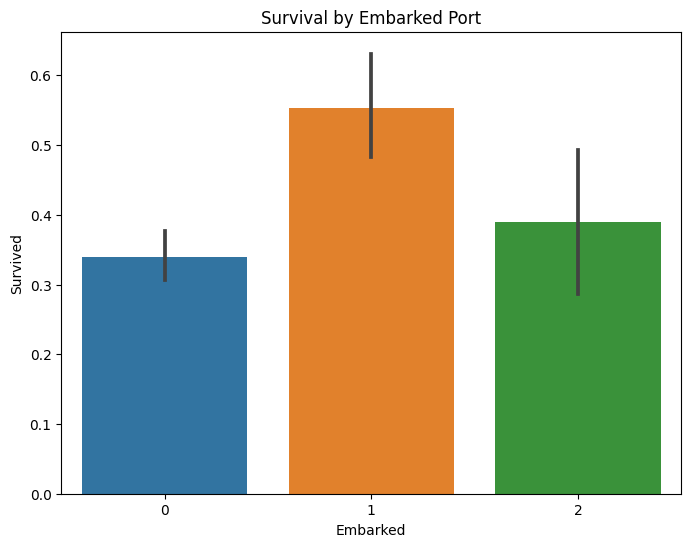

In [24]:
# 3. Survival Rates by Categorical Variables
# Survival by Sex
plt.figure(figsize=(8, 6))
sns.barplot(x='Sex', y='Survived', data=df)
plt.title('Survival by Sex')
plt.show()

# Survival by Pclass
plt.figure(figsize=(8, 6))
sns.barplot(x='Pclass', y='Survived', data=df)
plt.title('Survival by Pclass')
plt.show()

# Survival by Embarked
plt.figure(figsize=(8, 6))
sns.barplot(x='Embarked', y='Survived', data=df)
plt.title('Survival by Embarked Port')
plt.show()

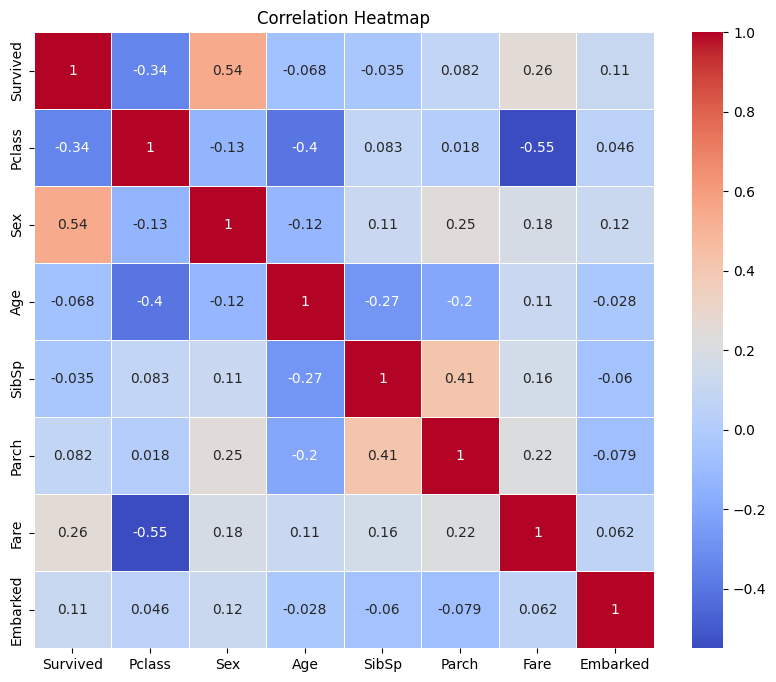

In [26]:
# 4. Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## Feature Selection

In [29]:
# Function to compute the metrics and return a dictionary
def compute_metrics(model, X_test, y_test):
    # Predictions and predicted probabilities
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Compute metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_prob)
    }

    return metrics

# Split the data into training and testing sets (30% for testing)
X = df.drop(columns=['Survived'])
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Train Logistic Regression on all features (baseline model)
model_all = LogisticRegression(max_iter=500)
model_all.fit(X_train, y_train)

# Compute metrics for the model with all features
metrics_all = compute_metrics(model_all, X_test, y_test)

# Backward stepwise feature selection
model_backward = LogisticRegression(max_iter=500)

# Use SequentialFeatureSelector for backward selection
backward_selector = SequentialFeatureSelector(model_backward, n_features_to_select="auto", direction='backward', scoring='accuracy')
backward_selector.fit(X_train, y_train)

# Get selected features and train the model
X_train_backward = backward_selector.transform(X_train)
X_test_backward = backward_selector.transform(X_test)

model_backward.fit(X_train_backward, y_train)

# Compute metrics for backward selection
metrics_backward = compute_metrics(model_backward, X_test_backward, y_test)

# Forward stepwise feature selection
model_forward = LogisticRegression(max_iter=500)

# Use SequentialFeatureSelector for forward selection
forward_selector = SequentialFeatureSelector(model_forward, n_features_to_select="auto", direction='forward', scoring='accuracy')
forward_selector.fit(X_train, y_train)

# Get selected features and train the model
X_train_forward = forward_selector.transform(X_train)
X_test_forward = forward_selector.transform(X_test)

model_forward.fit(X_train_forward, y_train)

# Compute metrics for forward selection
metrics_forward = compute_metrics(model_forward, X_test_forward, y_test)

# Create a DataFrame to store the results
results = pd.DataFrame({
    'All Features': metrics_all,
    'Backward Selection': metrics_backward,
    'Forward Selection': metrics_forward
}).T  # Transpose to have the models as rows

# Display the DataFrame
print(results)


                    Accuracy  Precision    Recall  F1-score   AUC-ROC
All Features        0.809701   0.800000  0.720721  0.758294  0.883514
Backward Selection  0.828358   0.821782  0.747748  0.783019  0.887933
Forward Selection   0.809701   0.812500  0.702703  0.753623  0.860561


In [45]:
selected_mask = backward_selector.get_support()

selected_features = X.columns[selected_mask].tolist()

selected_features

['Pclass', 'Sex', 'Age', 'SibSp']

## Balancing Techniques

In [46]:
# Recreate X (features) and y (target) from df
X = df[selected_features]  # All selected features from feature selection
y = df['Survived']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Step 1: Original model with no balancing
model.fit(X_train, y_train)
metrics_no_balancing = compute_metrics(model, X_test, y_test)

# Step 2: SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
model.fit(X_train_smote, y_train_smote)
metrics_smote = compute_metrics(model, X_test, y_test)

# Step 3: Random OverSampling
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
model.fit(X_train_ros, y_train_ros)
metrics_random_oversampling = compute_metrics(model, X_test, y_test)

# Step 4: Random UnderSampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
model.fit(X_train_rus, y_train_rus)
metrics_random_undersampling = compute_metrics(model, X_test, y_test)

# Step 5: NearMiss
nearmiss = NearMiss()
X_train_nearmiss, y_train_nearmiss = nearmiss.fit_resample(X_train, y_train)
model.fit(X_train_nearmiss, y_train_nearmiss)
metrics_nearmiss = compute_metrics(model, X_test, y_test)

# Step 6: Create DataFrame with results
results = pd.DataFrame({
    'No Balancing': metrics_no_balancing,
    'SMOTE': metrics_smote,
    'Random OverSampling': metrics_random_oversampling,
    'Random UnderSampling': metrics_random_undersampling,
    'NearMiss': metrics_nearmiss
}).T  # Transpose to have the models as rows

# Display the DataFrame
print(results)

                      Accuracy  Precision    Recall  F1-score   AUC-ROC
No Balancing          0.828358   0.821782  0.747748  0.783019  0.887933
SMOTE                 0.813433   0.747967  0.828829  0.786325  0.887187
Random OverSampling   0.805970   0.736000  0.828829  0.779661  0.885637
Random UnderSampling  0.805970   0.732283  0.837838  0.781513  0.888908
NearMiss              0.802239   0.726562  0.837838  0.778243  0.850577


## Model selection

In [49]:
# Define the models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVC': SVC(probability=True),  # Enable probability output for AUC
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

# Prepare the dataset (using the features selected by backward selection)
X = df[selected_features]  # Use the features selected by backward selection
y = df['Survived']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Initialize Stratified K-Fold (with shuffle)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function to compute metrics for cross-validated predictions (on training set)
def compute_metrics_cv(model, X_train, y_train, skf):
    y_pred = cross_val_predict(model, X_train, y_train, cv=skf)
    y_prob = cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')[:, 1]
    
    metrics = {
        'Accuracy': accuracy_score(y_train, y_pred),
        'Precision': precision_score(y_train, y_pred),
        'Recall': recall_score(y_train, y_pred),
        'F1-score': f1_score(y_train, y_pred),
        'AUC-ROC': roc_auc_score(y_train, y_prob)
    }
    return metrics

# Initialize a dictionary to store the results for each model
results = {}

# Evaluate each model using cross-validation on the training set and store the results
for model_name, model in models.items():
    metrics = compute_metrics_cv(model, X_train, y_train, skf)
    results[model_name] = metrics

# Convert the results dictionary into a DataFrame
results_df = pd.DataFrame(results).T  # Transpose to have models as rows

# Display the DataFrame with metrics for each model
print(results_df)

                     Accuracy  Precision    Recall  F1-score   AUC-ROC
Logistic Regression  0.792937   0.745192  0.670996  0.706150  0.838231
Random Forest        0.794543   0.735160  0.696970  0.715556  0.827817
SVC                  0.653291   0.682927  0.121212  0.205882  0.774235
K-Nearest Neighbors  0.739968   0.682540  0.558442  0.614286  0.764605
Decision Tree        0.783307   0.720183  0.679654  0.699332  0.777415
Gradient Boosting    0.808989   0.804348  0.640693  0.713253  0.838662
Naive Bayes          0.762440   0.681223  0.675325  0.678261  0.821821


## Hyperparameters tuning

In [ ]:
# Prepare the dataset (using the features selected by backward selection)
X = df[selected_features]  # Use the features selected by backward selection
y = df['Survived']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Define the hyperparameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Perform the grid search on the training set
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train the model with the best hyperparameters
best_model = grid_search.best_estimator_

# Evaluate the tuned model on the test set
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Compute metrics on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_prob)

# Create a DataFrame for the evaluation metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC'],
    'Score': [accuracy, precision, recall, f1, auc_roc]
})

# Display the DataFrame with evaluation metrics
print(metrics_df)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


## Model Evaluation